In [1]:
cd(@__DIR__)
include(raw"utils\utils.jl")

Undrift!

Making a calendar of 100 years

In [2]:
try 
    using Dates
catch ; 
    import Pkg
    Pkg.add("Dates")
    using Dates
end
k=100
DatesRange=collect(Date(1900):Day(1):Date(1900+k))
N=length(DatesRange)

36525

# AR model on the whole series

## AR(2)

In [3]:
condition(r) = (imag(r) == 0) && (abs(r) > 1)
isstationnary(R::Vector)=all(condition.(RootAR(R)))

isstationnary (generic function with 1 method)

In [4]:
x0=[7.,-3]
Φ,σ=[0.1,0.5],6
isstationnary([0.1,0.5])

true

In [5]:
include("utils/Simulation.jl")
x=[x0 ; simulation(x0,Φ,σ,N-length(x0))]

36525-element Vector{Float64}:
  7.0
 -3.0
  9.496661684227934
  8.058285729917467
  9.095483894520314
  3.8390310815127333
 10.304245377531132
  6.1618152167876
  3.062345569694387
 -7.983592296289016
  ⋮
  1.51646055405676
 -0.37735531725107974
  9.03444217241631
  6.098348939536191
  6.240665695121271
  8.904897404259945
 -3.1025639330106785
  7.83671434445176
  4.190327408683848

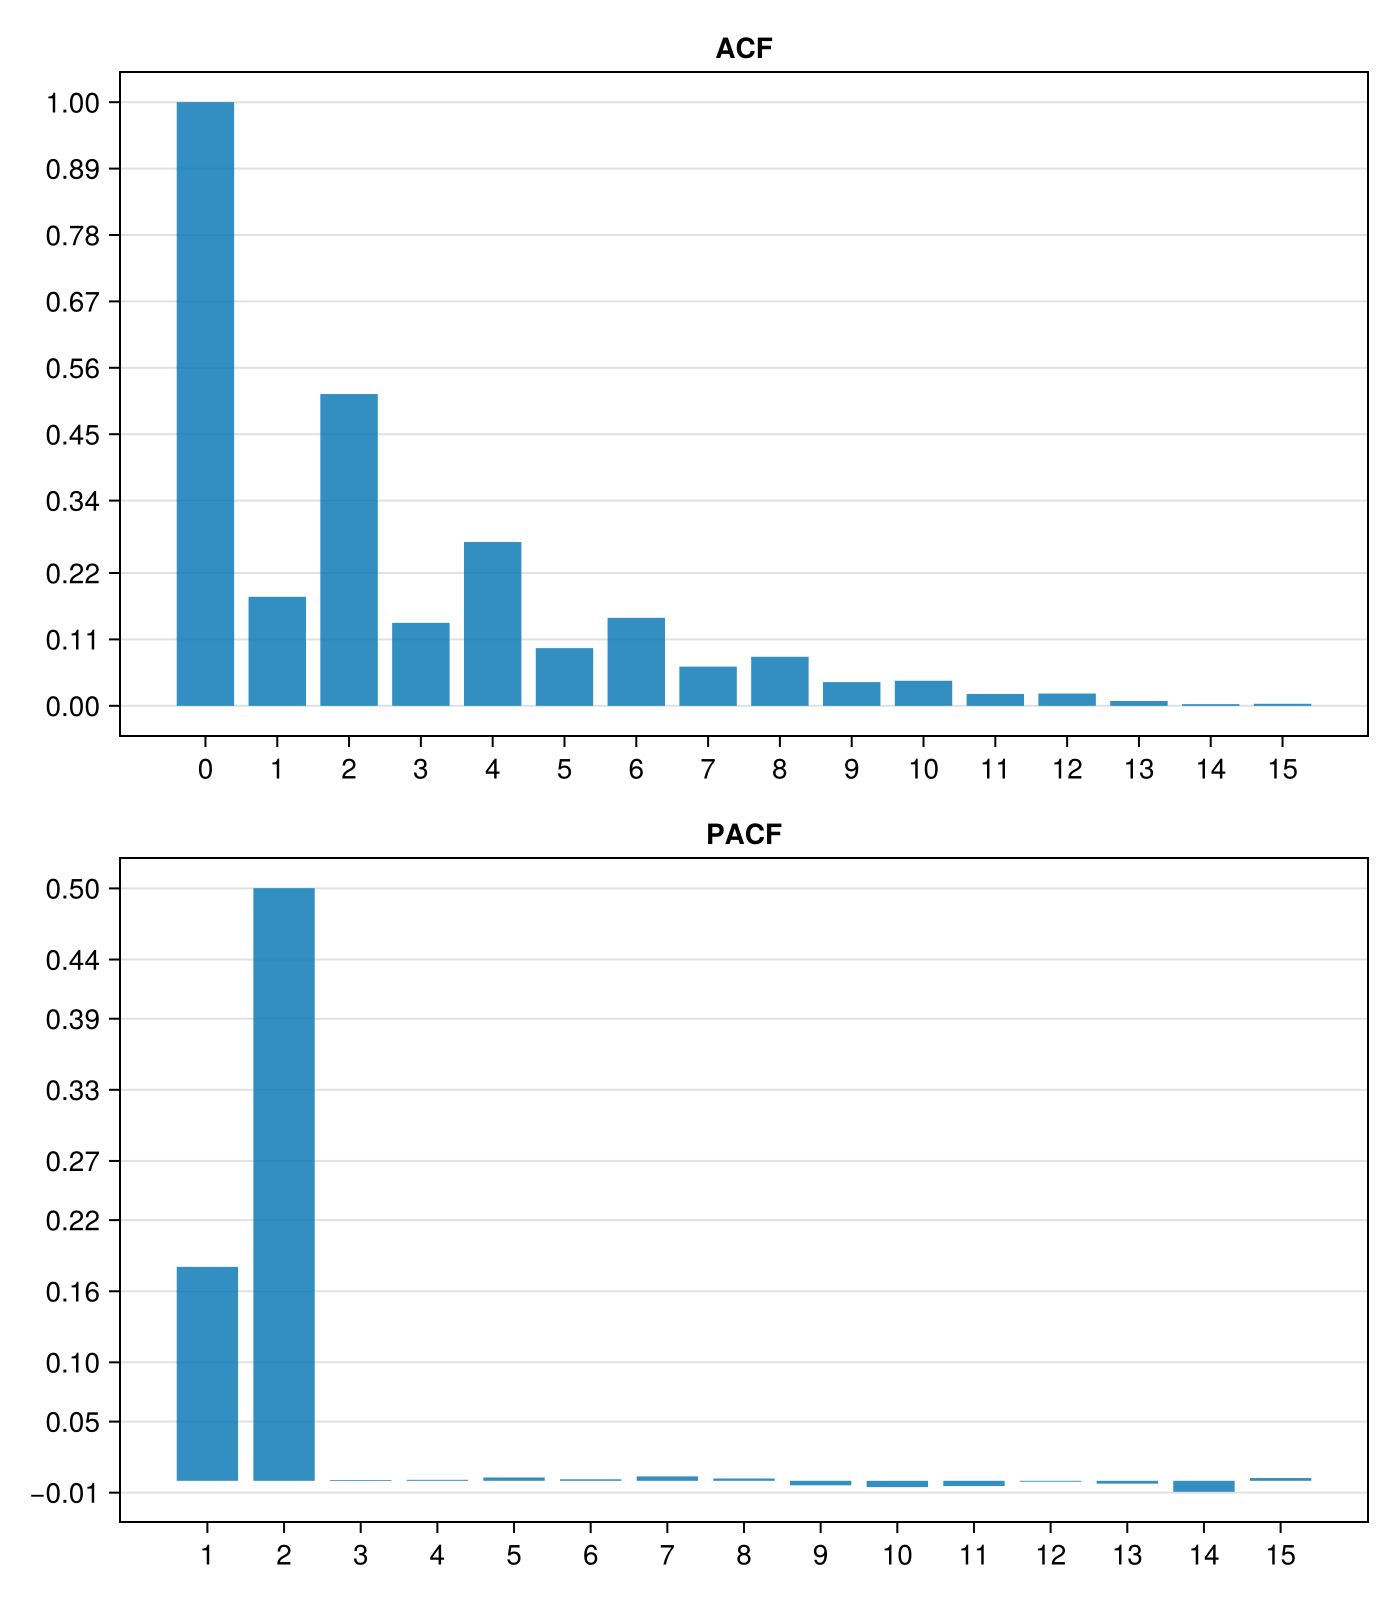

In [6]:
include("utils/ACF_PACF.jl")
ACF_PACF(x)

In [7]:
include("utils/Estimation.jl")
Parameters_est=LL_AR_Estimation(x,2)
Φ1_hat, Φ2_hat, σ_hat=Parameters_est[1][1], Parameters_est[1][2], Parameters_est[2]
table = DataFrame("Parameters"=>"Φ₁", "Error"=>abs(Φ1_hat-Φ[1]), "Relative error"=>abs(Φ1_hat-Φ[1])/abs(Φ[1]))
push!(table,("Φ₂",abs(Φ2_hat-Φ[2]),abs(Φ2_hat-Φ[2])/abs(Φ[2])))
push!(table,("σ",abs(σ_hat-σ),abs(σ_hat-σ)/abs(σ)))

Row,Parameters,Error,Relative error
,String,Float64,Float64
1,Φ₁,0.00972315,0.0972315
2,Φ₂,0.000196723,0.000393447
3,σ,0.0219016,0.00365027


# AR model on each month

Parameters for each month

To find convenient parameters, below I have made an empirical map of where the parameters make the AR(2) series stationnary (in blue) and where they don't (in red)

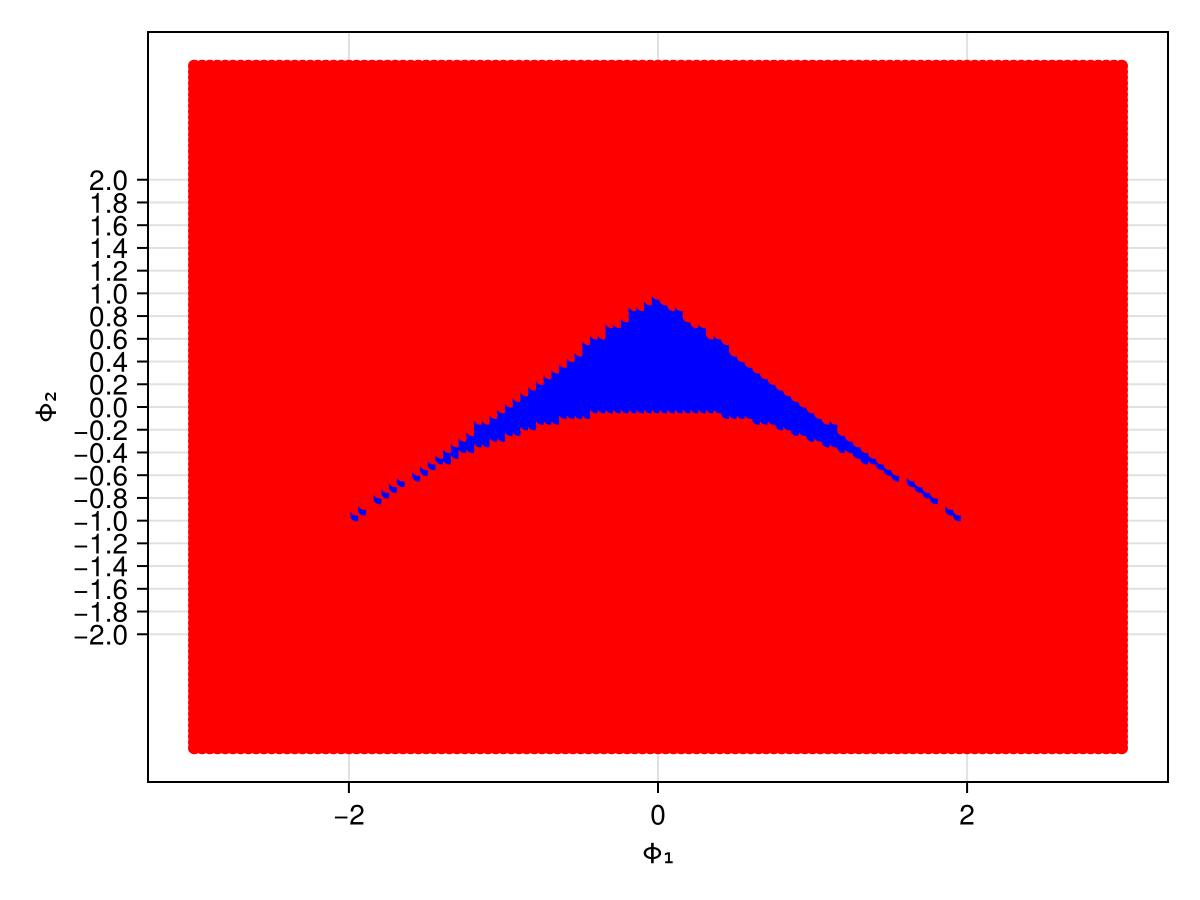

In [8]:
fig=Figure()
ax=Axis(fig[1,1])
ax.yticks=-2:0.2:2
Φ₁ls=-3:.05:3
Φ₂ls=-3:.05:3
condition(r) = (imag(r) == 0) && (abs(r) > 1)
for Φ₁ in Φ₁ls
    for Φ₂ in Φ₂ls
        color = all(condition.(RootAR([Φ₁,Φ₂]))) ? "blue" : "red" 
        scatter!(ax, Φ₁,Φ₂, color=color)
        ax.ylabel="Φ₂"
        ax.xlabel="Φ₁"
    end
end
fig

In [9]:
Φ_month=[[5,2],[-7,1],[1,8],[6,2],[-2,7],[0.5,9],[-3,2],[5,4],[3,1],[-4,3],[3,1],[5,2]] / 10
display(isstationnary.(Φ_month))
Φ1_month, Φ2_month = invert(Φ_month)
σ_month=[1.5,2,4.5,7,8,3,4.5,1,7,2.5,3,6]

12-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

12-element Vector{Float64}:
 1.5
 2.0
 4.5
 7.0
 8.0
 3.0
 4.5
 1.0
 7.0
 2.5
 3.0
 6.0

Generation of the series associated

In [25]:
n_month=200
x=SimulateMonth([7.,4.],Date(2000,11,2),Φ_month,σ_month,n_month)
Date_vec=collect(Date(2000,11,1):(Date(2000,11,1) + Month(n_month) - Day(1)))
Monthly_temp=MonthlySeparateX(x,Date_vec)

12-element Vector{Vector{AbstractVector}}:
 [[-5.803718373330167, -4.416061009513511, -1.5041561497939293, -2.791773130552661, -2.5987426232975586, 0.9759485816175331, -1.6921512123030273, -1.6867103415882563, -1.1993214541648387, -0.11898545049829634  …  -1.383369370529183, 1.717223195759061, 3.3955307793609477, 2.8183203847998035, -2.039221809118308, 0.3088788365617485, -0.43221430020022683, 2.6229400049620013, -2.085222504890503, -1.2734502940198813], [3.7539237035317927, 1.5604725115455071, -0.9828124050132365, 0.017783833763480944, -3.87769918995797, -2.7838446660661873, -2.311236355874472, -1.4195398614734085, 0.002694640720080077, 2.3759942649122134  …  5.547217767921533, 4.409823421342386, 5.798054036708159, 3.1863098026340855, 2.8609806283592274, 2.9373590266482816, 3.339912195734992, 2.4357223256623515, 2.208015576973806, 1.4263333752461262], [-3.0482581516932514, -5.560087134037385, -3.6004557682241964, -2.770593040409362, -2.830437548950371, -3.7490307010980737, -3.13663161

## Autocorrelations

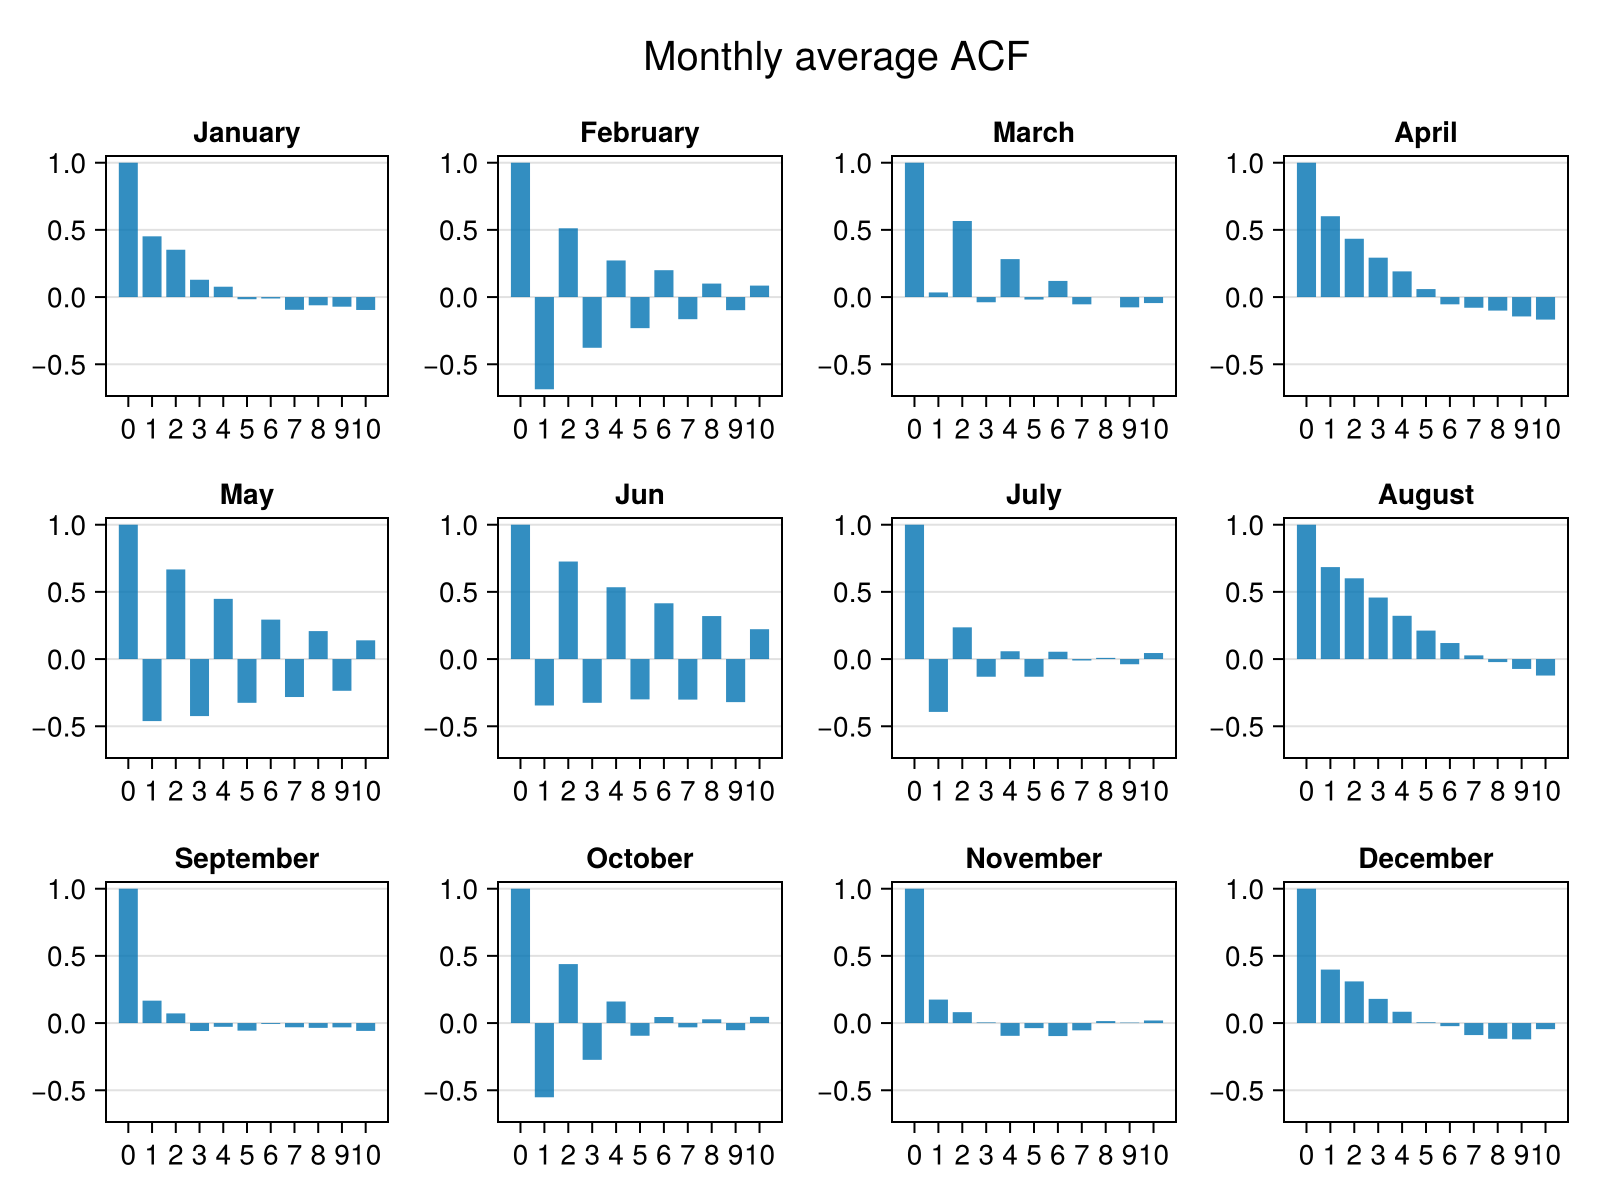

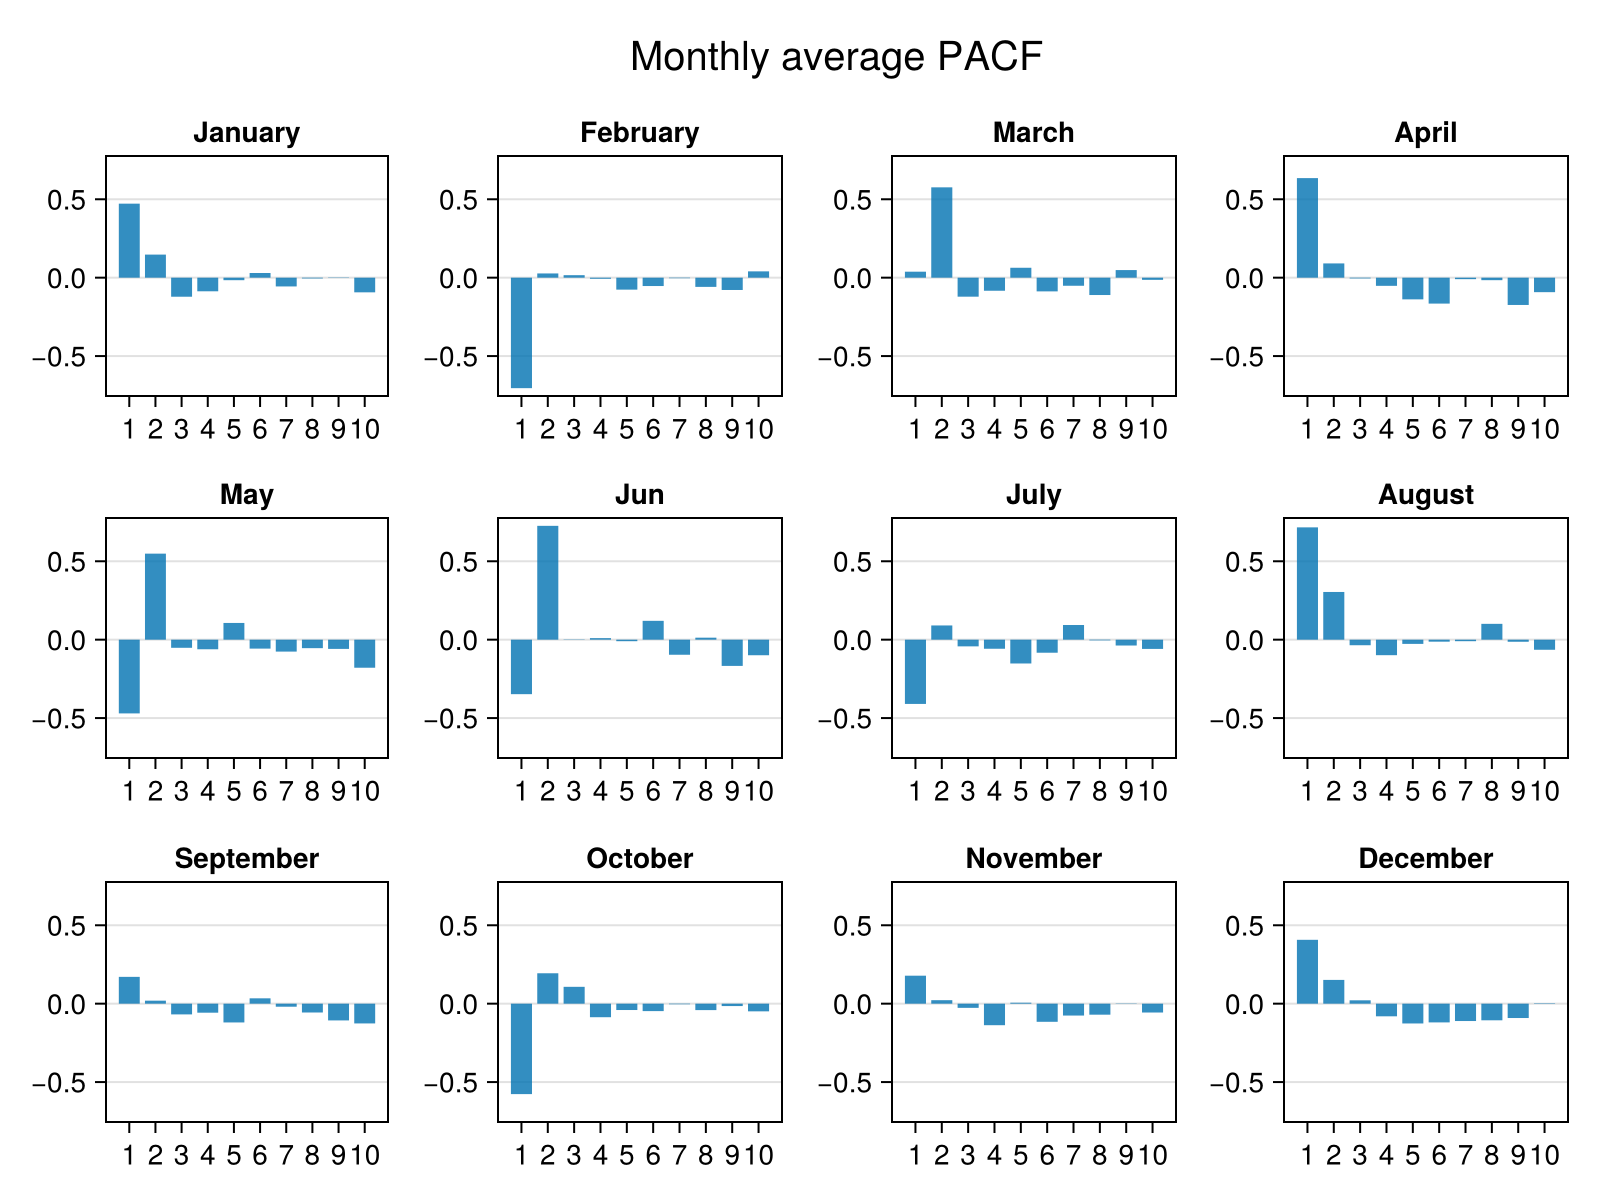

CairoMakie.Screen{IMAGE}


In [26]:
display(MonthlyACF(Monthly_temp))
display(MonthlyPACF(Monthly_temp))

## Estimating models

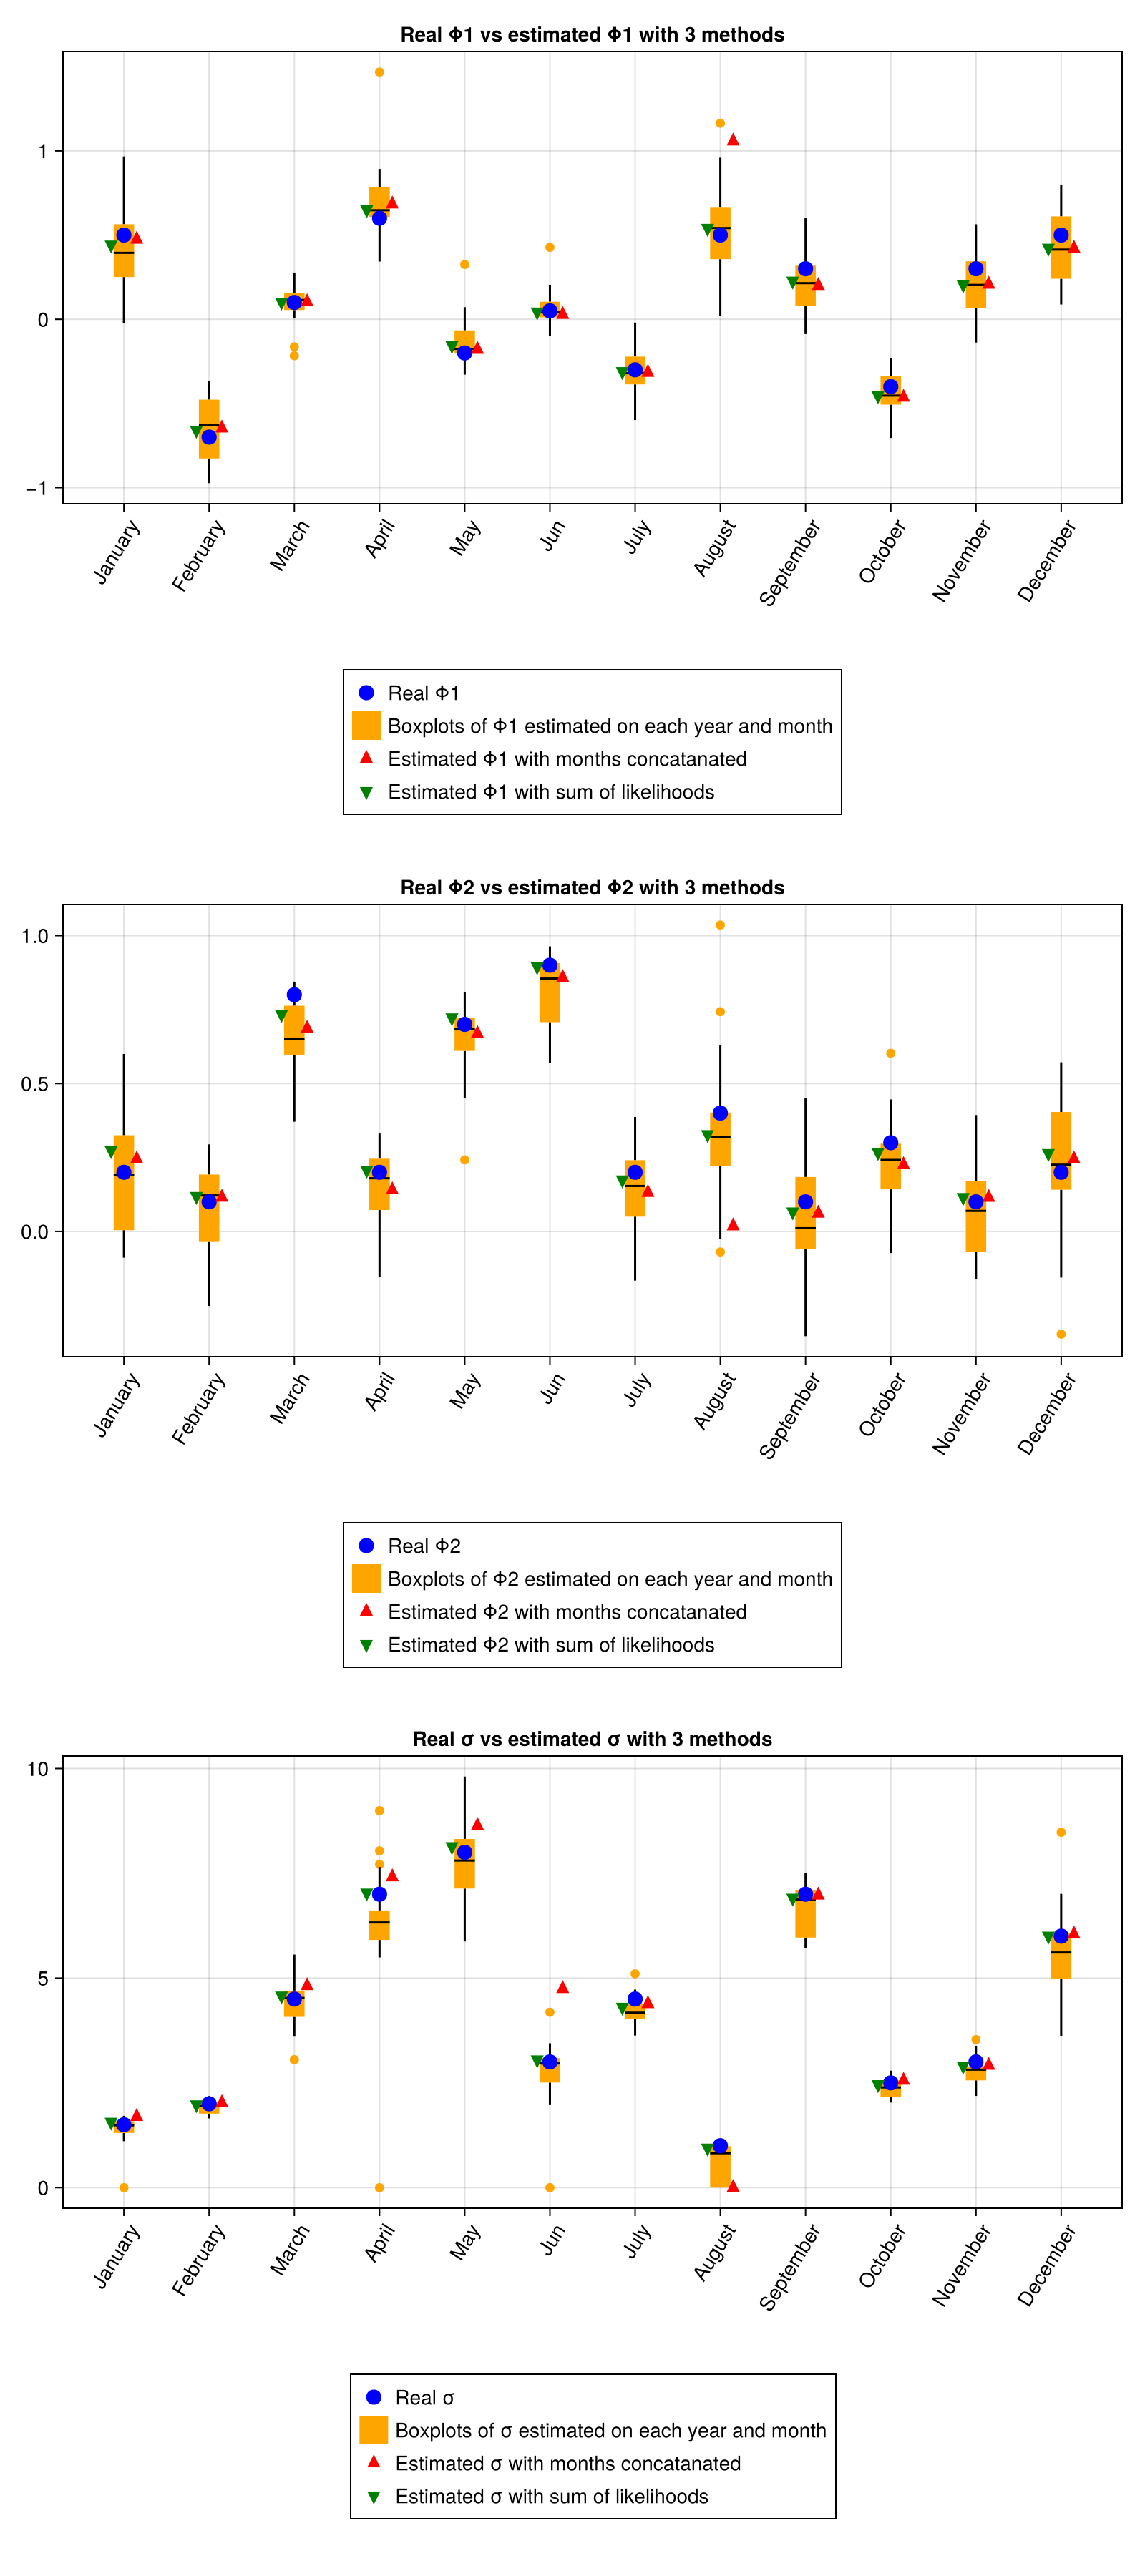

Row,Parameter,Month concatanation,Sum LL,mean of monthly parameters,median of monthly parameters
,String,Float64,Float64,Float64,Float64
1,Φ1,24.6994,13.2336,18.1251,15.8782
2,Φ2,26.7939,16.1518,20.0599,21.4139
3,σ,16.8441,2.21037,9.18867,5.11647


6

In [27]:
include(raw"utils\Estimation.jl")
Parameters,autofig,ErrorTable=AllEstimation(x,2,Date_vec=Date_vec,TrueParamVec=[Φ1_month,Φ2_month,σ_month])
display(autofig)
display(ErrorTable)

In [28]:
Φ_vec, σ_vec = AutoTakeParameters((Parameters,ErrorTable))
n_years=100
sim=SimulateYears([7.,4.],Date(2001,1,2),Φ_vec, σ_vec,n_years)
sample_=invert(sim)

365-element Vector{Vector{Float64}}:
 [7.0, 1.4299430150583352, -0.5647616189634734, -3.6545701048472146, 6.320563192769568, -3.206238309470173, -3.5244255124388806, -6.40210480909508, -4.187160907570065, -6.294625535949969  …  6.120367313364492, -2.1216854613426714, -5.779182682478155, 8.206376526786874, -9.401829147438736, -10.902927476880143, -2.1171304600337075, -10.88971482285166, 2.7066512853942863, 0.48185258840548506]
 [4.0, 1.5860554103973856, 0.9241887443690776, -1.6493312682597359, 6.005225124278747, -0.653855983907369, -0.026858685771355528, -7.69813507593234, -3.4173414510498406, -6.001173877027476  …  4.377530426577067, -3.9518406343243626, -3.4468033086499683, 7.309969305764687, -4.4850751290411806, -7.799002974632716, -0.3688745389814221, -7.35664888621243, 6.425649426219611, -0.025607272544492465]
 [1.5926727543489476, -0.4380577251583855, -0.73267430523756, -4.1332280250252325, 3.920849895541811, -1.6976786240483859, 0.7722943776048553, -5.63024927716659, -0.628083207

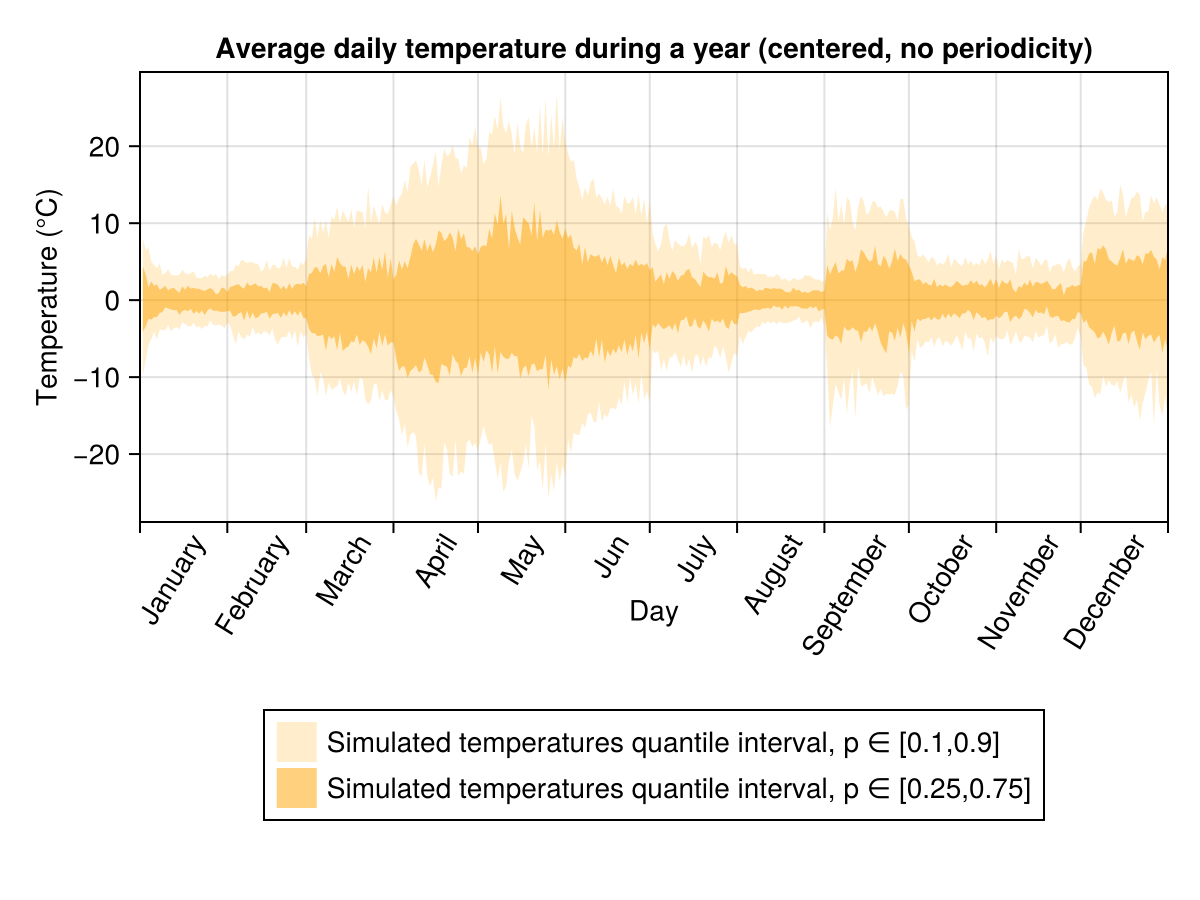

In [29]:
include("utils/Plotting.jl")
PlotYearCurves([],
["Simulated temperatures quantile interval, p ∈ [0.1,0.9]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered, no periodicity)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
)